In [ ]:
# Notre DIP
!git clone https://github.com/quentgar/dip-inpainting-registration.git
!mv dip-inpainting-registration/* ./

Cloning into 'dip-inpainting-registration'...
remote: Enumerating objects: 1397, done.
remote: Counting objects: 100% (836/836), done.
remote: Compressing objects: 100% (542/542), done.
remote: Total 1397 (delta 425), reused 523 (delta 250), pack-reused 561
Receiving objects: 100% (1397/1397), 89.48 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (678/678), done.


In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from src.utils import *
from src.Quentin.rototranslation import *
from src.hourglass_network import *
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from skimage.measure import compare_psnr

import cv2
import math as m

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
dtype = torch.cuda.FloatTensor

dim_div_by = 32
PLOT = True

In [ ]:
img_path = 'mydata/recalage/image1.jpg'
mask_path = 'mydata/recalage/image1_mask.jpg'

In [ ]:
img_np = format_image(img_path, dim_div_by)
img_mask_np = format_image(mask_path, dim_div_by)

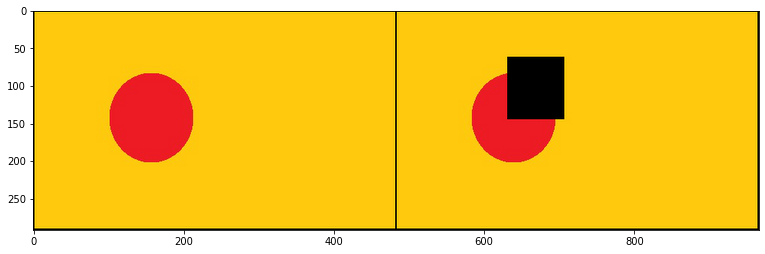

In [ ]:
plot_image_grid([img_np, img_np*img_mask_np], 3,11);

In [ ]:
size = img_np.shape[1:]
img_np.shape

(3, 288, 480)

In [ ]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
show_every = 100
figsize = 5
reg_noise_std = 0.03
depth = 3

# ATTENTION : etages_roto liste pour i dans [0..depth-1] depth-1 étant le fond du réseau et 0 la couche la plus haute

net_inpainting = build_hourglass_roto(input_depth, output_depth=img_np.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,
               filter_size_up = 5, filter_size_down = 5,
               orientations_nb=8, filter_roto=5,
               etages_roto=[1],
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [ ]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net_inpainting.parameters())
print ('Number of params inpainting: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params inpainting: 6695811


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


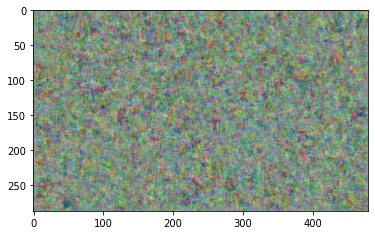

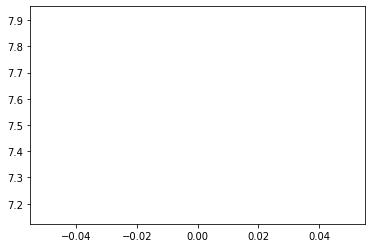

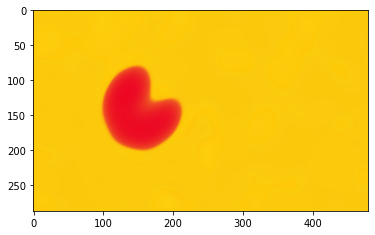

In [ ]:
i = 0
list_iter = []
list_psnr = []
list_loss = []

best_loss = 10
best_psnr = 0
best_iter = 0
best_out = None

show_psnr = 300

num_iter = 1500

def closure():
    
    global i, list_iter, list_psnr, list_loss, best_loss, best_psnr, best_iter, best_out
    
    
    net_input = net_input_saved

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net_inpainting(net_input)
   
    total_loss = mse(out.to('cuda:0') * mask_var.to('cuda:0'), img_var.to('cuda:0') * mask_var.to('cuda:0')).to('cuda:0')
    total_loss.backward()

    out_np = torch_to_np(out)
    psnr_gt = compare_psnr(img_np,out_np)

    if psnr_gt > best_psnr:
      best_loss = total_loss.item()
      best_psnr = psnr_gt
      best_iter = i
      best_out = out
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        list_iter.append(i)
        list_psnr.append(psnr_gt)
        list_loss.append(total_loss.item())
        #plt.imshow(out_np.transpose(1,2,0))
        #plt.show()
        plot_image_grid([np.clip(torch_to_np(out), 0, 1)], factor=5, nrow=2)

        if i % show_psnr == 0:
          plt.figure()
          plt.plot(list_iter,list_psnr)
          plt.show()
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(net_inpainting)

optimize(p, closure, LR, num_iter)

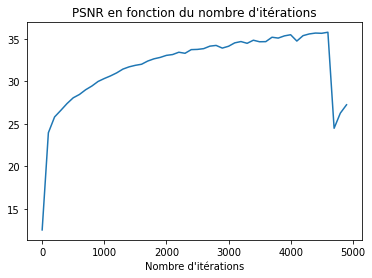

In [ ]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

In [ ]:
out_np = torch_to_np(best_out)

In [ ]:
t = out_np.transpose(1,2,0)*255
im = Image.fromarray(t.astype(np.uint8))
im.save('res_cercle_rouge.jpg')

In [ ]:
t = (img_np.transpose(1,2,0)*img_mask_np.transpose(1,2,0))*255
im = Image.fromarray(t.astype(np.uint8))
im.save('cercle_masked.jpg')